<center><h2>K-omo solucionar Bogotá</h2></center>
<center><h2>Un acercamiento aplicado a K-Means y Clusters en Machine Learning</h2></center>
<center><h3>Juan David Dueñas Garavito</h3></center>


<h3>Ruta de trabajo</h3>
<p>Durante la investigación en el urbanismo de Bogotá se han podido detallar problemas con la configuración y distribución de las zonas residenciales y laborales de la ciudad, generando desigualdades en el empleo de tiempo de transporte entre los diferentes niveles de ingreso, esto lo detalla Peña, J., Guzman, L. A., & Arellana, J. (2022) calculando EC (Employment centers) a partir de la Encuesta de Movilidad </p>

<p> El presente trabajo tiene como objetivo dar un abordaje metodologico alternativo a este problema urbanistico. Por medio de aprendizaje de maquinas (Machine Learning) en especifico el algoritmo de clasificación K-means vamos a clusterizar cada una de las estaciones de Transmilenio en dos categorias, estación residencial y estación laboral a partir de la distribución de validaciones en el sistema troncal de Transmilenio a lo largo de un dia elegido al azar. </p>

<p> Este trabajo es relevante en la medida en la que aporta una metodologia nueva al análisis del problema ubanistico de Bogotá utilizando fuentes de información poblacional que pueden contener elementos que se escapan a las tradicionales fuentes de información muestral. </p>

<p> Este trabajo lo vamos a desarrollar en los siguientes pasos </p>

     - Empezamos detallando que es el algoritmo de k-means
     - Hablamos de las aplicaciones a urbanismo y datos espaciales
     - Introducimos el problema urbanistico de Bogotá
     - Hacemos Data-Cleaning
     - Corremos Algoritmo de K-Means para cluserizar estaciones de TM
     - Concluimos

<h2>¿Que es k-means y k-nearest neigthbor?</h2>  

<h3>K-means</h3>

Podemos decir que K-means es un metodo de clustering no supervisado en donde buscamos identificar y agrupar datos según k similitudes, el algoritmo que veremos más adelante busca asignar cada dato a alguno de los k grupos minimizando la varianza dentro de los grupos y maximizando la varianza entre los grupos. es decir, el objeto del algoritmo es formar conjuntos cuyos integrantes sean muy parecidos y que los conjuntos entre si sean muy diferentes.

Este algoritmo funciona de la siguente manera: sus inputs son unos datos y un número K, primero se generan k centroides y se le da a cada uno una posición geografica aleatoria, posterior empezamos la iteración de los siguientes dos pasos:

     - Asignamos cada dato a su centroide más cercano en función de la distancia cuadrada euclidiana, 
       matematicamente se puede ver de la siguiente manera:
       
<center> 
    $\underset{c_i}{\text{min}}\, dist(c_{i}, x)^2$
</center>

    - actualizamos la posición de los centroides, la nueva posición del centroide j será determinada a partir de la media de
      todos los puntos del grupo j, matematicamente se puede ver de la siguiente manera:
    
<center>
    $c_j = \frac{1}{|S_j|}\sum_{x_i \in S_j} x_i$
</center>

Esta iteración va a terminar convergiendo a un punto en el cual la posición de los centroides despues de cada iteración no va a cambiar significativamente.


<h3>Ejemplo</h3>

Inciamos importando las librerias para llevar a cabo este algoritmo, a su vez que creamos un dataframe de ejemplo 

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

mall_customers = load_iris(as_frame=True)
X = mall_customers.data.values

Visualizamos el Dataframe

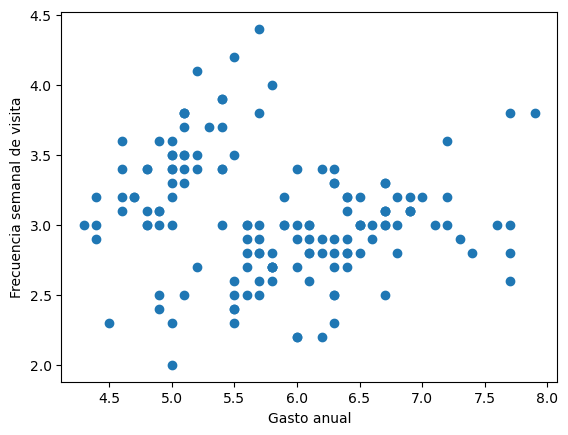

In [2]:
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('Gasto anual')
plt.ylabel('Frecuencia semanal de visita')
plt.show()

Estandarizamos (media = 0 y varianza unitaria) los datos para posteriormente aplicar el kmeans con k=2 es decir dos conjuntos de datos, lo visualizamos con Matplotlib y le pedimos que nos permita ver la posición de los 2 centroides generados

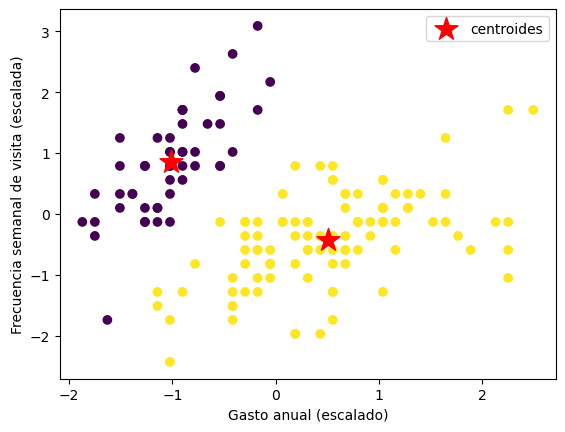

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans.labels_)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            color='r', label='centroides')
plt.legend()
plt.xlabel('Gasto anual (escalado)')
plt.ylabel('Frecuencia semanal de visita (escalada)')
plt.show()

<h2>El problema de Bogotá </h2>

Bogotá actualmente se encuentra en las ciudades con peores traficos en el mundo, compitiendo con ciudades con densidades poblacionales muy altas, el problema de Bogotá no solo se limita al trafico sino tambien este problema se ve reflejado en el servicio del sistema de transporte masivo, en este caso Transmilenio. Las principales hipotesis de este problema radican en que el problema no es la configuración del sistema de transporte masivo, el cual de hecho es ejemplo en la región, sino en la distribución tan desigual y lejana espacialmente entre las principales zonas residenciales y laborales de la ciudad.

Para confirmar esta hipotesis con datos poblacionales, vamos a analizar el comportamiento de Transmilenio durante un dia promedio, haciendo especial enfasis en las distribuciones de validaciones en cada una de las estaciones del sistema. 

In [82]:
import requests
import numpy as np
import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from shapely.geometry import Point
import contextily as ctx
import plotly.express as px
import imageio
import kaleido
from io import BytesIO
from PIL import Image
pd.options.mode.chained_assignment = None
import plotly.io as pio
import scipy.stats as stats
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from shapely.ops import nearest_points


Descargamos un dataset desde los datos abiertos de transmilenio, especificamente las validaciones del componente troncal

In [83]:
os.chdir("C:/Users/PC/Documents/Repos/K-omo_solucionar_Bog")

In [84]:
if not os.path.isfile("../datos/tm/validacionTroncal20230213.csv"):
    url = 'https://storage.googleapis.com/validaciones_tmsa/ValidacionTroncal/validacionTroncal20230213.csv'
    response = requests.get(url)

    with open('../datos/tm/validacionTroncal20230213.csv', 'wb') as file:
        file.write(response.content)
else:
    print("ARCHIVO YA EXISTE")

ARCHIVO YA EXISTE


Abrimos el Dataset en Pyton para hacer un adecuado proceso de EDA, identificamos variables, fomatos, posibles datos nulos y seleccionamos las variables que son de nuestro interes (Estacion_Parada y Fecha_transacción en este caso).

In [85]:
data = pd.read_csv("../datos/tm/validacionTroncal20230213.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933333 entries, 0 to 1933332
Data columns (total 22 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Acceso_Estacion             object 
 1   Day_Group_Type              object 
 2   Dispositivo                 int64  
 3   Emisor                      object 
 4   Estacion_Parada             object 
 5   Fase                        object 
 6   Fecha_Clearing              object 
 7   Fecha_Transaccion           object 
 8   Hora_Pico_SN                object 
 9   ID_Vehiculo                 float64
 10  Linea                       object 
 11  Nombre_Perfil               object 
 12  Numero_Tarjeta              object 
 13  Operador                    object 
 14  Ruta                        float64
 15  Saldo_Despues_Transaccion   float64
 16  Saldo_Previo_a_Transaccion  float64
 17  Sistema                     object 
 18  Tipo_Tarifa                 int64  
 19  Tipo_Tarjeta         

In [86]:
data.isnull().sum()

Acceso_Estacion                     0
Day_Group_Type                      0
Dispositivo                         0
Emisor                              0
Estacion_Parada                     0
Fase                                0
Fecha_Clearing                      0
Fecha_Transaccion                   0
Hora_Pico_SN                        0
ID_Vehiculo                   1933333
Linea                               0
Nombre_Perfil                       0
Numero_Tarjeta                      0
Operador                            0
Ruta                          1933333
Saldo_Despues_Transaccion           0
Saldo_Previo_a_Transaccion          0
Sistema                             0
Tipo_Tarifa                         0
Tipo_Tarjeta                        0
Tipo_Vehiculo                 1933333
Valor                               0
dtype: int64

In [87]:
data.head()

,Acceso_Estacion,Day_Group_Type,Dispositivo,Emisor,Estacion_Parada,Fase,Fecha_Clearing,Fecha_Transaccion,Hora_Pico_SN,ID_Vehiculo,...,Numero_Tarjeta,Operador,Ruta,Saldo_Despues_Transaccion,Saldo_Previo_a_Transaccion,Sistema,Tipo_Tarifa,Tipo_Tarjeta,Tipo_Vehiculo,Valor
0,(01) Acceso Peatonal Oriental,Dia 1,650000187,(3101000) Bogota Card(Citizen),(06101) El Tiempo,Fase 3,2023-02-13,2023-02-09 17:10:04,Peak Time,NaN,...,1418b2335cf1f3046a6f6cdc6753738e8cbfbbcb859c9e...,(201) Trunk agency,NaN,2700.0,5650.0,TRONCAL,1,tullave Básica,NaN,2950.0
1,(01) Acceso Peatonal Oriental,Dia 1,650000187,(3101000) Bogota Card(Citizen),(06101) El Tiempo,Fase 3,2023-02-13,2023-02-09 17:10:07,Peak Time,NaN,...,9bb6a348bb551dce8ed2722cba5952d2a3a4ad64fd6d53...,(201) Trunk agency,NaN,72200.0,75150.0,TRONCAL,1,tullave Básica,NaN,2950.0
2,(01) Acceso Peatonal Oriental,Dia 1,650000187,(3101000) Bogota Card(Citizen),(06101) El Tiempo,Fase 3,2023-02-13,2023-02-09 17:10:09,Peak Time,NaN,...,ae8bba7198445b384a9dc4d3e3070e6b1cac305175080c...,(201) Trunk agency,NaN,40500.0,43450.0,TRONCAL,1,tullave Plus,NaN,2950.0
3,(01) Acceso Peatonal Oriental,Dia 1,650000187,(3101000) Bogota Card(Citizen),(06101) El Tiempo,Fase 3,2023-02-13,2023-02-09 17:10:12,Peak Time,NaN,...,f60eb33d0d9a384baf461d904e9fdb4d06c1968c47a367...,(201) Trunk agency,NaN,8200.0,11150.0,TRONCAL,1,tullave Plus,NaN,2950.0
4,(01) Acceso Peatonal Oriental,Dia 1,650000187,(3101000) Bogota Card(Citizen),(06101) El Tiempo,Fase 3,2023-02-13,2023-02-09 17:10:15,Peak Time,NaN,...,91ed4f30f14a62df0b9c7e52b0b5d1f902d0e332c9da76...,(201) Trunk agency,NaN,24450.0,27400.0,TRONCAL,1,tullave Básica,NaN,2950.0


In [88]:
Estaciones = data[["Estacion_Parada","Fecha_Transaccion"]].copy()
Estaciones["nombre_est"] = Estaciones["Estacion_Parada"].str[8:]
Estaciones.head()

,Estacion_Parada,Fecha_Transaccion,nombre_est
0,(06101) El Tiempo,2023-02-09 17:10:04,El Tiempo
1,(06101) El Tiempo,2023-02-09 17:10:07,El Tiempo
2,(06101) El Tiempo,2023-02-09 17:10:09,El Tiempo
3,(06101) El Tiempo,2023-02-09 17:10:12,El Tiempo
4,(06101) El Tiempo,2023-02-09 17:10:15,El Tiempo


Dividimos la fecha entre fecha (dia, mes y año) y hora para luego volverlos un dato de tiempo, más facil de manejar

In [89]:
Estaciones["Fecha_Transaccion"] = pd.to_datetime(Estaciones["Fecha_Transaccion"])
#data["hora"] = pd.to_datetime(data["hora"], format="%m/%d/%Y, %H:%M:%S")

Ahora analizamos los datos de las fechas para entender la extensión de nuestro DataSet

In [90]:
Estaciones['Fecha_Transaccion'].dt.day.value_counts()

13    1933101
9         134
14         98
Name: Fecha_Transaccion, dtype: int64

Nos damos cuenta que el grueso de los datos se encuentra el 13 de febrero. Por ende, limitamos nuestra base de datos a las validaciones ocurridas durante esta fecha y graficamos la frecuencia por tiempo de las validaciones en el sistema troncal, ademas de eliminar datos atipicos generados en horas fuera del funcionamiento de Transmilenio

In [91]:
Estaciones13Feb = Estaciones.loc[Estaciones["Fecha_Transaccion"].dt.day == 13]
Estaciones13Feb = Estaciones13Feb.loc[Estaciones["Fecha_Transaccion"].dt.hour >= 5]
Estaciones13Feb = Estaciones13Feb.loc[Estaciones["Fecha_Transaccion"].dt.hour <= 22]

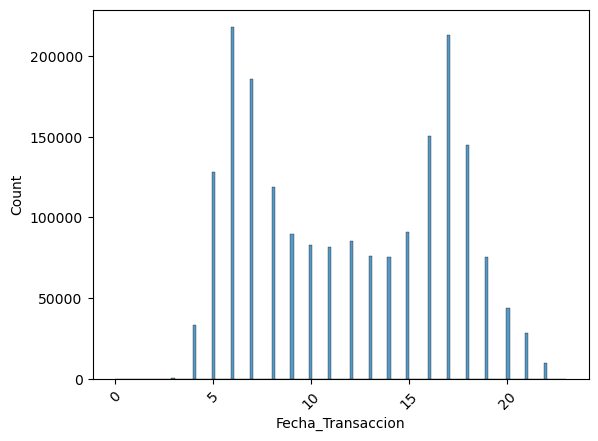

In [92]:
sns.histplot(data=Estaciones13Feb, x=Estaciones["Fecha_Transaccion"].dt.hour)
plt.xticks(rotation=45)
plt.show()

Cada una de las estaciones va a tener una distribución diferente de validaciones a lo largo del dia, la hipotesis radica en que las estaciones se dividen en 2 tipos, las estaciones residenciales y las estaciones laborales. En las primeras vamos a encontrar más validaciones en la hora pico de la mañana mientras que en las segundas vamos a encontrar más validaciones de lo normal en la hora pico de la tarde. Para esto vamos a graficar dos estaciones de ejemplo

Empezamos con lo que considerariamos una estación laboral, calle 100

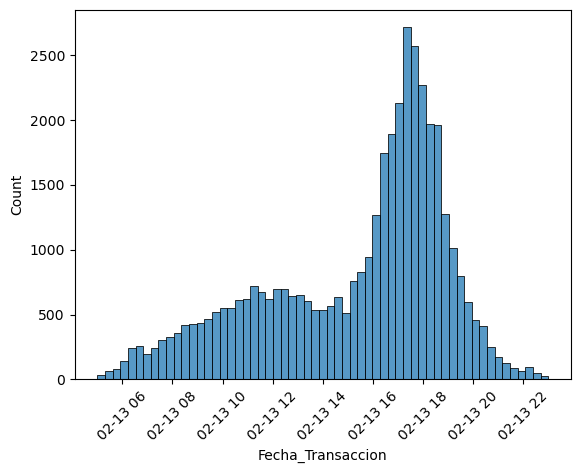

In [141]:
Estaciones13Feb.groupby(by='nombre_est') 
estacion_calle100 = Estaciones13Feb.groupby('nombre_est').get_group("Calle 100")

sns.histplot(data=estacion_calle100, x=estacion_calle100["Fecha_Transaccion"])
plt.xticks(rotation=45)
plt.show()

Como nos podemos dar cuenta la mayoria de validaciones de esta estación se encuentra en horas de la tarde, por otro lado una estación residencial como patio bonito tiene la siguiente distribución:

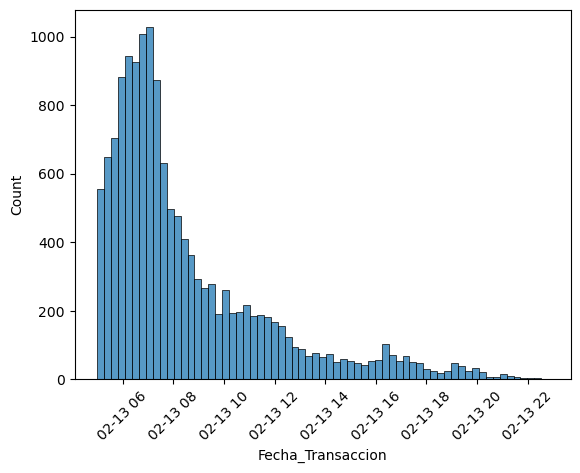

In [94]:
estacion_patio_bonito = Estaciones13Feb.groupby('nombre_est').get_group("Patio Bonito")

sns.histplot(data=estacion_patio_bonito, x=estacion_patio_bonito["Fecha_Transaccion"])
plt.xticks(rotation=45)
plt.show()

Es decir cada estación tiene su propia distribución durante el transcurso del día, para visualizar esto de mejor manera podemos ayudarnos de heatmaps que hagan cortes transversales a las distribuciones durante el dia.

Para esto empezamos a integrar los datos espaciales, importamos el Shapefile previamente descargado en nuestro local y visualizamos cada una de la ubicaciones espaciales de las estaciones de Trasmilenio sobre el mapa de Bogotá

In [96]:
troncales_shapefile = gpd.read_file("../datos/tm/Estaciones_Troncales_de_TRANSMILENIO.shp")
troncales_shapefile["longitud_y_latitud"] = troncales_shapefile["geometry"]
troncales_shapefile["longitud_y_latitud"] = troncales_shapefile["longitud_y_latitud"].astype(str)
troncales_shapefile["longitud_y_latitud"] = troncales_shapefile["longitud_y_latitud"].str[7:-1]


troncales_shapefile[['longitud', 'latitud']] = troncales_shapefile['longitud_y_latitud'].str.split(' ', 1, expand=True)
troncales_shapefile.head()

,objectid,numero_est,nombre_est,coordenada,coordena_1,ubicacion_,troncal_es,numero_vag,numero_acc,biciestaci,...,last_edite,last_edi_1,codigo_nod,componente,componen_1,log_replic,geometry,longitud_y_latitud,longitud,latitud
0,1,07103,AV. Chile,1.000327e+06,1.007756e+06,Kr 30 Cl 72,NQS,6,2,0,...,NaN,NaN,7103,NaN,NaN,NaN,POINT (-74.07456 4.66634),-74.0746 4.66634,-74.0746,4.66634
1,2,06103,CAN,9.976100e+05,1.005604e+06,Carrera 60,Calle 26,4,1,0,...,NaN,NaN,6103,NaN,NaN,NaN,POINT (-74.09905 4.64688),-74.099 4.64688,-74.099,4.64688
2,3,07106,Campín,9.998678e+05,1.005440e+06,Kr 30 Cl 53,NQS,2,2,0,...,NaN,NaN,7106,NaN,NaN,NaN,POINT (-74.07870 4.64540),-74.0787 4.6454,-74.0787,4.6454
3,4,10008,San Diego,1.000667e+06,1.001625e+06,Kra 10- Cl23,Cr 7-10,2,2,0,...,NaN,NaN,10008,NaN,NaN,NaN,POINT (-74.07150 4.61090),-74.0715 4.6109,-74.0715,4.6109
4,5,04100,Granja - Carrera 77,9.979466e+05,1.011384e+06,Carrera 77 Bis,Calle 80,3,2,0,...,NaN,NaN,4100,NaN,NaN,NaN,POINT (-74.09602 4.69915),-74.096 4.69915,-74.096,4.69915


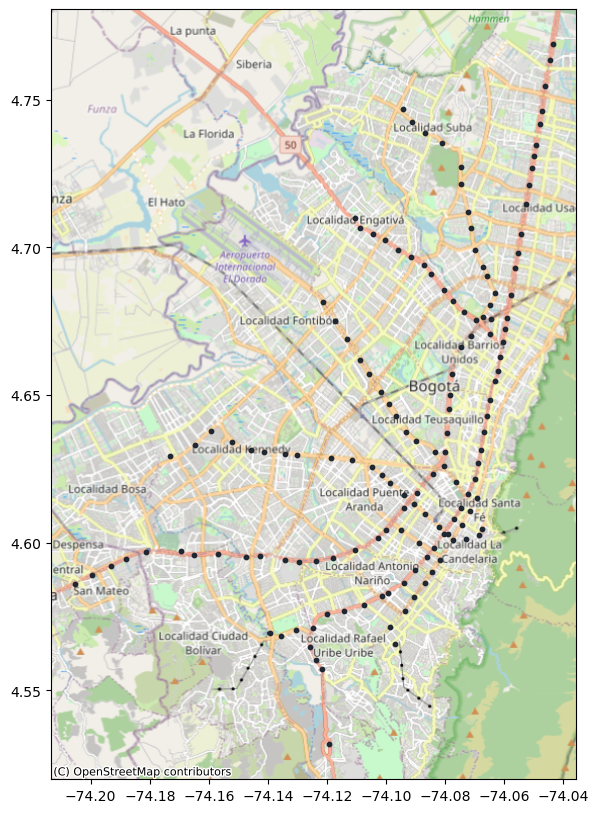

In [97]:
fig, ax = plt.subplots(figsize=(10, 10))
troncales_shapefile.plot(ax=ax, color="#1f2733", markersize=10, alpha=1)
ctx.add_basemap(ax, crs=troncales_shapefile.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

In [98]:
Estaciones13Feb.head()

,Estacion_Parada,Fecha_Transaccion,nombre_est
34194,(03000) Portal Suba,2023-02-13 05:00:00,Portal Suba
34195,(04000) Cabecera Calle 80,2023-02-13 05:00:00,Cabecera Calle 80
34196,(05000) Portal Américas,2023-02-13 05:00:00,Portal Américas
34197,(05000) Portal Américas,2023-02-13 05:00:00,Portal Américas
34198,(05000) Portal Américas,2023-02-13 05:00:00,Portal Américas


Ahora vamos a hacer unas modificaciones a los datasets con el fin de tener una columna igual en ambas bases de datos, creando de esta manera la llave para poder realizar un merge de forma adecuada 

In [99]:
EstacionesHH = Estaciones13Feb.groupby(["Estacion_Parada" ,pd.Grouper(key='Fecha_Transaccion', freq='30min')]).count().reset_index()
EstacionesHH["numero_est"] = EstacionesHH["Estacion_Parada"].str[1:6]
EstacionesHH.head()

,Estacion_Parada,Fecha_Transaccion,nombre_est,numero_est
0,(02000) Cabecera Autopista Norte,2023-02-13 05:00:00,1896,02000
1,(02000) Cabecera Autopista Norte,2023-02-13 05:30:00,3285,02000
2,(02000) Cabecera Autopista Norte,2023-02-13 06:00:00,4646,02000
3,(02000) Cabecera Autopista Norte,2023-02-13 06:30:00,5195,02000
4,(02000) Cabecera Autopista Norte,2023-02-13 07:00:00,5677,02000


Creamos los cortes tranversales de las distribuciones de cada una de las estaciones de Transmilenio agrupando las validaciones cada media hora, por cada corte transversal vamos a crear un heatmap que nos muestre la densidad de uso geograficamente y en un momento del dia especifico.

In [100]:
print(os.getcwd())
if not os.path.exists("../datos/tm/heatmap/"):
    os.mkdir("../datos/tm/heatmap")

if not os.path.isfile("../datos/tm/heatmap/heatmap0.png"):
    lista_cortes = []
    
    for i in range(5, 23):
        lista_cortes.append("2023-02-13"+" "+str(i)+":00:00")
        lista_cortes.append("2023-02-13"+" "+str(i)+":30:00")

    nombre_cortes = lista_cortes.copy()
    mapa_cortes = lista_cortes.copy()

    for i in range(len(nombre_cortes)):
        nombre_cortes[i] = "corte"+" "+str(nombre_cortes[i])

    for i in range(len(mapa_cortes)):
        mapa_cortes[i] = "mapa"+" "+str(mapa_cortes[i])

    for i in range(len(nombre_cortes)):
        nombre_cortes[i] = EstacionesHH["Fecha_Transaccion"] == lista_cortes[i]
        nombre_cortes[i] = EstacionesHH[nombre_cortes[i]]
        nombre_cortes[i].rename(columns={"nombre_est": "Validaciones"}, inplace=True)
        nombre_cortes[i] = pd.merge(troncales_shapefile, nombre_cortes[i], on="numero_est")
        mapa_cortes[i] = px.density_mapbox(nombre_cortes[i], 
                            lat='latitud', 
                            lon='longitud', 
                            z='Validaciones', 
                            radius=20, 
                            center=dict(lat=4.64688, lon=-74.099), 
                            zoom=10,
                            title = lista_cortes[i],
                            mapbox_style='open-street-map')
        ruta_archivo = "../datos/tm/heatmap/heatmap"+str(i)+".png"
        pio.write_image(mapa_cortes[i], ruta_archivo, format='png', width=800, height=600)
else:
    print("archivo ya existe")

C:\Users\PC\Documents\Repos\K-omo_solucionar_Bog
archivo ya existe


Dado que se generaron 35 heatmaps, para una pedagogía más adecuada vamos a gruparlos en un GIF con lo cual podremos ver dinamicamente como el nivel de las validaciones van variando geograficamente en el sistema de transporte, con esto podremos fijarnos en que en horas de la mañana la mayoria de validaciones se encuentran en zonas perifericas de la ciudad, mientras que en horas de la tarde la mayoria de validaciones se encuentran espacialmente cerca a los lugares que Peña, J., Guzman, L. A., & Arellana, J. (2022) identificaron como EC(Employment Centers)

In [101]:
print(os.getcwd())
if not os.path.isfile("../datos/tm/heatmap/output.gif"):
    os.chdir("C:/Users/PC/Documents/Repos/datos/tm/heatmap")
    heatmaps = []
    for i in range(35):
        nombre_heatmap = "heatmap"+str(i)+".png"
        heatmaps.append(nombre_heatmap)

    heatmaps_pil = [Image.open(imagen) for imagen in heatmaps]

    heatmaps_pil = [imagen.convert('RGB') for imagen in heatmaps_pil]

    heatmaps_pil[0].save('output.gif', save_all=True, append_images=heatmaps_pil[1:], duration = 500, loop=0)

    print("¡El GIF ha sido creado exitosamente!")
    os.chdir("C:/Users/PC/Documents/Repos/K-omo_solucionar_Bog")   
else:
    print("El archivo ya existe")


C:\Users\PC\Documents\Repos\K-omo_solucionar_Bog
El archivo ya existe


Como el GIF no se puede visualizar en este archivo, le invito al lector a acceder al siguiente link de mi Drive en el cual podrá ver el archivo:

https://drive.google.com/file/d/1Q_YZD2isREY59YKz_q-UA6pOIB3aLIZi/view?usp=drive_link

Ahora debemos aplicar el algoritmo de K-means, para esto debemos crear las variables a partir de las cuales vamos a hacer la clusterización, dada la naturaleza de nuestro proyecto usaremos dos caracteristicas por cada estación, como nos interesa evaluar el sesgo de la distribución, la primera caracteristica va a ser el coeficiente de asimetría de fisher y la segunda caracteristica un indice propio.

Dividimos nuestro dataset en dos, mañana y tarde ademas creamos listas dentro de diccionarios que contengan las diferentes cantidades de validaciones cada 30 min

In [102]:
validaciones_mañana, validaciones_tarde = Estaciones13Feb[:len(Estaciones13Feb)//2], Estaciones13Feb[len(Estaciones13Feb)//2:]

In [103]:
estaciones_mañana_intervalo = validaciones_mañana.groupby(["Estacion_Parada", pd.Grouper(key='Fecha_Transaccion', freq='30min')]).count().reset_index()
estaciones_tarde_intervalo = validaciones_tarde.groupby(["Estacion_Parada" ,pd.Grouper(key='Fecha_Transaccion', freq='30min')]).count().reset_index()
estaciones_mañana_intervalo["numero_est"] = estaciones_mañana_intervalo["Estacion_Parada"].str[1:6]
estaciones_tarde_intervalo["numero_est"] = estaciones_tarde_intervalo["Estacion_Parada"].str[1:6]
estaciones_mañana_intervalo.head()

,Estacion_Parada,Fecha_Transaccion,nombre_est,numero_est
0,(02000) Cabecera Autopista Norte,2023-02-13 05:00:00,1896,02000
1,(02000) Cabecera Autopista Norte,2023-02-13 05:30:00,3285,02000
2,(02000) Cabecera Autopista Norte,2023-02-13 06:00:00,4646,02000
3,(02000) Cabecera Autopista Norte,2023-02-13 06:30:00,5195,02000
4,(02000) Cabecera Autopista Norte,2023-02-13 07:00:00,5677,02000


Ahora creamos unos diccionarios vacios, en los cuales las llaves serán los nombres de todas las estaciones de Transmilenio y los valores serán el número de validaciones cada media hora por cada estación.

In [104]:
lista_mañana = dict()
lista_tarde = dict()
lista_dia = dict()

for i in estaciones_mañana_intervalo["Estacion_Parada"]:
    lista_mañana[str(i)] = []
    lista_tarde[str(i)] = []
    lista_dia[str(i)] = []

for j, l in zip(estaciones_mañana_intervalo["Estacion_Parada"], estaciones_mañana_intervalo["nombre_est"]):
        lista_mañana[j].append(l)

for y, z in zip(estaciones_tarde_intervalo["Estacion_Parada"], estaciones_tarde_intervalo["nombre_est"]):
        lista_tarde[y].append(z)
        
for j, l in zip(EstacionesHH["Estacion_Parada"], EstacionesHH["nombre_est"]):
        lista_dia[j].append(l)


Vamos a calcular el indice propio el cual es la diferencia entre el valor maximo alcanzado por la mañana y el valor maximo alcanzado por la tarde, con esto podremos cuantificar la diferencia en magnitud de la hora pico de la mañana y de la tarde, el numero entre más negativo, mas tendiente a ser una estación laboral y entre más positivo, mas tendiente a ser una estación residencial, al diferenciar superamos el problema de la diferencia de magnitudes entre cada una de las estaciones

In [105]:
maximo_mañana = dict()
maximo_tarde = dict()
diferencia = dict()

for i in estaciones_mañana_intervalo["Estacion_Parada"]:
    maximo_mañana[str(i)] = []
    maximo_tarde[str(i)] = []
    diferencia[str(i)] = []

for i in lista_mañana.keys():
    maximo_mañana[i] = np.log(max(lista_mañana[i]))

for i in lista_tarde.keys():
    maximo_tarde[i] = np.log(max(lista_tarde[i]))

for i in lista_dia.keys():
    diferencia[i] = maximo_mañana[i] - maximo_tarde[i]

Ahora calculamos el coeficiente de fisher y pearson para cada una de las estaciones

In [106]:
pearson = dict()
fisher = dict()

for i in EstacionesHH["Estacion_Parada"]:
    pearson[str(i)] = []
    fisher[str(i)] = []

for i in lista_dia.keys():
    dia_array = np.array(lista_dia[i])
    fisher[i] = skew(dia_array)


convertimos los diccionarios en datasets con el fin de hacer un joint y tener un formato más comodo para correr el k-means

In [107]:
df_diferencia = pd.DataFrame.from_dict(diferencia, orient='index', columns=[""])
df_diferencia["dataset"] = df_diferencia.index

df_fisher = pd.DataFrame.from_dict(fisher, orient='index', columns=[""])
df_fisher["dataset"] = df_fisher.index


df = pd.merge(df_diferencia, df_fisher, on='dataset', how='inner')
df.columns = ["diferencia", "Estacion_Parada", "fisher"]
df = df.reindex(columns=['Estacion_Parada', 'diferencia', "fisher"])
df = df.dropna()
df["numero_est"] = df["Estacion_Parada"].str[1:6]

In [108]:
df

,Estacion_Parada,diferencia,fisher,numero_est
0,(02000) Cabecera Autopista Norte,0.447466,0.756385,02000
1,(02001) Centro Comercial Santa Fe,0.904673,1.755713,02001
2,(02101) Toberín,0.638087,1.288913,02101
3,(02102) Calle 161,0.389717,1.032363,02102
4,(02103) Mazurén,0.522726,0.900935,02103
...,...,...,...,...
150,(40000) Cable Portal Tunal,-1.875105,1.508704,40000
151,(40001) Juan Pablo II,1.836211,1.807520,40001
152,(40002) Manitas,1.855708,1.732941,40002
153,(40003) Mirador del Paraiso,1.936778,1.889893,40003


dado que tenemos 2 caracteristicas vamos a graficar las estaciones en un espacio teorico en función del indice propio y el coeficiente de asimetria de fisher

Text(0, 0.5, 'coeficiente de asimetría de fisher')

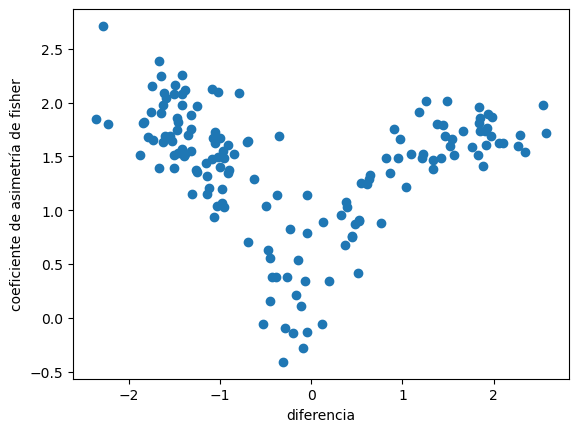

In [109]:
plt.scatter(df["diferencia"], df["fisher"])
plt.xlabel('diferencia')
plt.ylabel('coeficiente de asimetría de fisher')

Corremos el K-means

In [110]:
X = np.array(df[["fisher", "diferencia"]])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
etiquetas = list(kmeans.labels_)

Graficamos el resultado

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


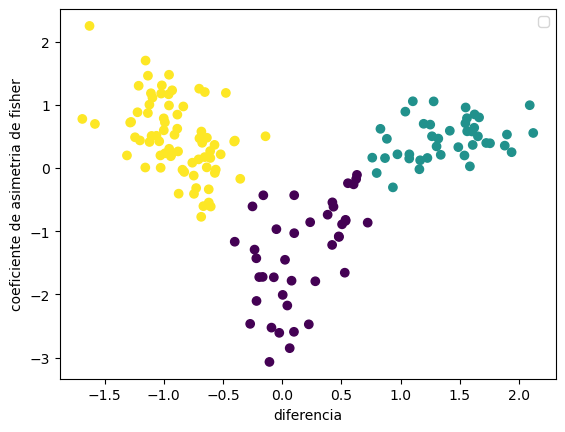

In [111]:
plt.scatter(X_scaled[:, 1], X_scaled[:, 0], c=kmeans.labels_)
centroids = kmeans.cluster_centers_

plt.legend()
plt.xlabel('diferencia')
plt.ylabel('coeficiente de asimetria de fisher')
plt.show()

Añadimos la clasificación a la lista de estaciones

In [112]:
assert len(df) == len(etiquetas)
etiquetas = np.array(etiquetas)
df = np.column_stack((df, etiquetas))
df
df = pd.DataFrame(df, columns=["Estacion_Parada","diferencia","fisher","numero_est","cluster"])

In [126]:
df.head()

,Estacion_Parada,diferencia,fisher,numero_est,cluster
0,(02000) Cabecera Autopista Norte,0.447466,0.756385,02000,0
1,(02001) Centro Comercial Santa Fe,0.904673,1.755713,02001,1
2,(02101) Toberín,0.638087,1.288913,02101,0
3,(02102) Calle 161,0.389717,1.032363,02102,0
4,(02103) Mazurén,0.522726,0.900935,02103,0
5,(02104) Calle 146,0.610521,1.240175,02104,0
6,(02105) Calle 142,0.483769,0.86888,02105,0
7,(02200) Alcalá,-0.141854,0.539255,02200,0
8,(02201) Prado,-0.498442,1.035212,02201,0
9,(02202) Calle 127,-1.246883,1.355356,02202,2


hacemos un joint con el shapefile para graficar

In [114]:
df_estaciones_shp = pd.merge(troncales_shapefile, df, on='numero_est')

In [115]:
df_estaciones_shp.head()

,objectid,numero_est,nombre_est,coordenada,coordena_1,ubicacion_,troncal_es,numero_vag,numero_acc,biciestaci,...,componen_1,log_replic,geometry,longitud_y_latitud,longitud,latitud,Estacion_Parada,diferencia,fisher,cluster
0,1,07103,AV. Chile,1.000327e+06,1.007756e+06,Kr 30 Cl 72,NQS,6,2,0,...,NaN,NaN,POINT (-74.07456 4.66634),-74.0746 4.66634,-74.0746,4.66634,(07103) AV. CHILE,-1.595363,2.045764,2
1,2,06103,CAN,9.976100e+05,1.005604e+06,Carrera 60,Calle 26,4,1,0,...,NaN,NaN,POINT (-74.09905 4.64688),-74.099 4.64688,-74.099,4.64688,(06103) CAN,-1.759302,1.909812,2
2,3,07106,Campín,9.998678e+05,1.005440e+06,Kr 30 Cl 53,NQS,2,2,0,...,NaN,NaN,POINT (-74.07870 4.64540),-74.0787 4.6454,-74.0787,4.6454,(07106) EL CAMPIN,-1.457684,1.528806,2
3,4,10008,San Diego,1.000667e+06,1.001625e+06,Kra 10- Cl23,Cr 7-10,2,2,0,...,NaN,NaN,POINT (-74.07150 4.61090),-74.0715 4.6109,-74.0715,4.6109,(10008) San Diego,-1.673976,1.39659,2
4,5,04100,Granja - Carrera 77,9.979466e+05,1.011384e+06,Carrera 77 Bis,Calle 80,3,2,0,...,NaN,NaN,POINT (-74.09602 4.69915),-74.096 4.69915,-74.096,4.69915,(04100) Carrera 77,1.090875,1.519111,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,145,12004,San Fason Carrera 22,9.989787e+05,1.001506e+06,Av. Americas -Carrera 22,Americas,2,2,0,...,NaN,NaN,POINT (-74.08671 4.60982),-74.0867 4.60982,-74.0867,4.60982,(12004) Carrera 22,-1.508342,1.508822,2
145,146,09003,Socorro,9.946663e+05,9.965122e+05,Carrera 16B - Carrera 14A,Caracas,2,2,0,...,NaN,NaN,POINT (-74.12557 4.56466),-74.1256 4.56466,-74.1256,4.56466,(09003) Socorro,1.331806,1.380246,1
146,147,03003,21 Ángeles,9.996288e+05,1.015397e+06,Av Suba Cl 136,Suba,2,1,0,...,NaN,NaN,POINT (-74.08085 4.73543),-74.0809 4.73543,-74.0809,4.73543,(03003) 21 ANGELES,0.954757,1.484136,1
147,148,09115,Calle 34,1.000860e+06,1.002807e+06,Avenida Calle 34 - Calle 3,Caracas,3,2,0,...,NaN,NaN,POINT (-74.06975 4.62159),-74.0698 4.62159,-74.0698,4.62159,(09115) Calle 34,-1.414082,1.972724,2


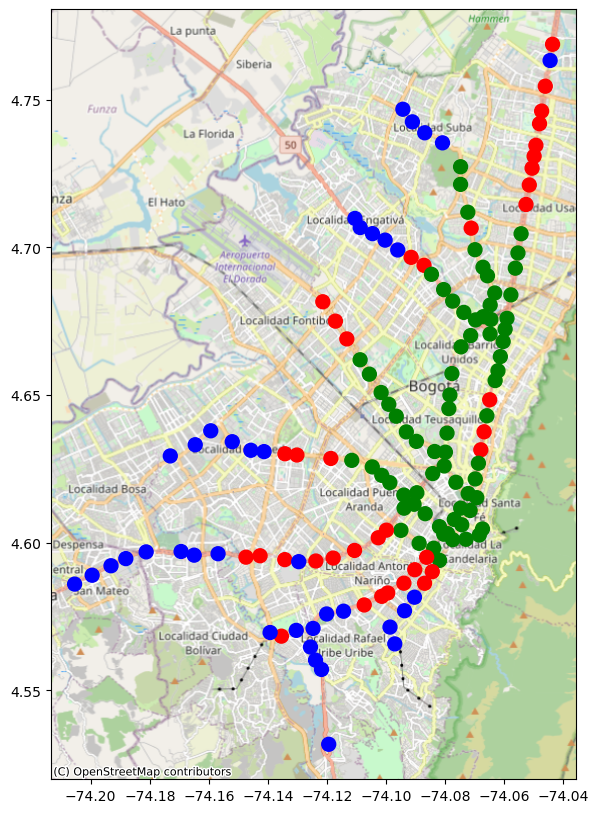

In [125]:
fig, ax = plt.subplots(figsize=(10, 10))

conditions = [
    df_estaciones_shp['cluster'] == 0,
    df_estaciones_shp['cluster'] == 1,
    df_estaciones_shp['cluster'] == 2
]

colors = np.select(conditions, ['red', 'blue', 'green'])

ax.scatter(df_estaciones_shp.geometry.x, df_estaciones_shp.geometry.y, color=colors, s=100, alpha=1)
ctx.add_basemap(ax, crs=df_estaciones_shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

In [142]:
X = np.array(df[["fisher", "diferencia"]])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
etiquetas = list(kmeans.labels_)

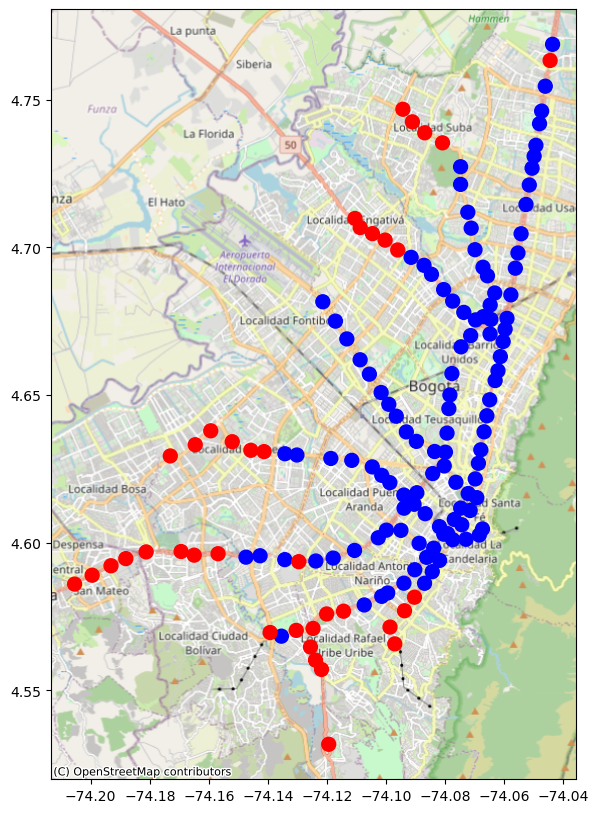

In [143]:
fig, ax = plt.subplots(figsize=(10, 10))
colors = np.where(df_estaciones_shp['cluster']==1, 'red', 'blue')
ax.scatter(df_estaciones_shp.geometry.x, df_estaciones_shp.geometry.y, color=colors, s=100, alpha=1)
ctx.add_basemap(ax, crs=df_estaciones_shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

<h2>segunda etapa</h2>

Ahora vamos a realizar un KNN con K=1 en el cual vamos a relacionar los precios comerciales de las estaciones con su estación de trasmilenio más cercana, esto con el fin de hallar una variable proxy de los ingresos de las personas que usan las diferentes estaciones de transmilenio

Iniciamos importando el shapefie desde local, para posteriormente graficarlo y 

In [117]:
os.chdir("C:/Users/PC/Documents/Repos/K-omo_solucionar_Bog")
avaluo_manzana_shapefile = gpd.read_file("../datos/tm/Avaluo_Manzana.shp")

avaluo_manzana_shapefile


,OBJECTID,MANZANA_ID,CP_TERR_AR,GRUPOP_TER,AVALUO_COM,AVALUO_CAT,OBSERVACIO,GLOBALID,SHAPE_Leng,SHAPE_Area,geometry
0,1,009259086,N,RESIDENCIAL,951874.0,733096.0,Este valor corresponde a la mediana y puede di...,{70BABE94-C17D-48FC-ADD0-BEF0283A45B4},0.002464,1.213815e-07,"POLYGON ((-74.12100 4.74751, -74.12101 4.74747..."
1,2,001355027,N,RESIDENCIAL,973208.0,666239.0,Este valor corresponde a la mediana y puede di...,{73AA8E80-CC4E-4DF5-887F-E1620A2356E4},0.000684,2.818937e-08,"POLYGON ((-74.09776 4.55222, -74.09776 4.55221..."
2,3,001355010,N,RESIDENCIAL,1100000.0,818602.0,Este valor corresponde a la mediana y puede di...,{ED6BDEF8-72FB-40F3-B4B5-A979800F5B47},0.000875,2.915943e-08,"POLYGON ((-74.09745 4.55194, -74.09747 4.55190..."
3,4,001355012,N,RESIDENCIAL,687104.0,469428.0,Este valor corresponde a la mediana y puede di...,{2EBCB819-9A4E-4F41-9A8B-0578AE28045A},0.001018,3.175301e-08,"POLYGON ((-74.09723 4.55258, -74.09718 4.55258..."
4,5,001355021,N,RESIDENCIAL,697258.0,474940.0,Este valor corresponde a la mediana y puede di...,{F25CC9EA-C4FA-49D6-9878-5EF2EBEE73FA},0.002131,9.812038e-08,"POLYGON ((-74.09668 4.55296, -74.09673 4.55288..."
...,...,...,...,...,...,...,...,...,...,...,...
43842,43843,002539009,N,RESIDENCIAL,613216.0,411971.0,Este valor corresponde a la mediana y puede di...,{1F31D653-612E-4058-A22C-F0B6DEAB66D2},0.002613,3.146819e-07,"POLYGON ((-74.15042 4.54514, -74.15038 4.54521..."
43843,43844,009263068,N,RESIDENCIAL,800000.0,561146.0,Este valor corresponde a la mediana y puede di...,{0904C68C-4568-4831-A0C9-B6903E3B0565},0.008599,1.403546e-06,"POLYGON ((-74.08607 4.72440, -74.08606 4.72440..."
43844,43845,NaN,NaN,NaN,0.0,0.0,Este valor corresponde a la mediana y puede di...,{3DF9EEB9-E5F8-40A2-B290-5DEC0C7F88AB},0.004493,1.263776e-06,"POLYGON ((-74.20958 4.62905, -74.21049 4.62863..."
43845,43846,001325032,N,LOTES,196734.0,163072.0,Este valor corresponde a la mediana y puede di...,{13FD0455-4AB7-41E9-9B7C-C0DA25854E31},0.015094,5.541504e-06,"POLYGON ((-74.08883 4.52689, -74.08883 4.52688..."


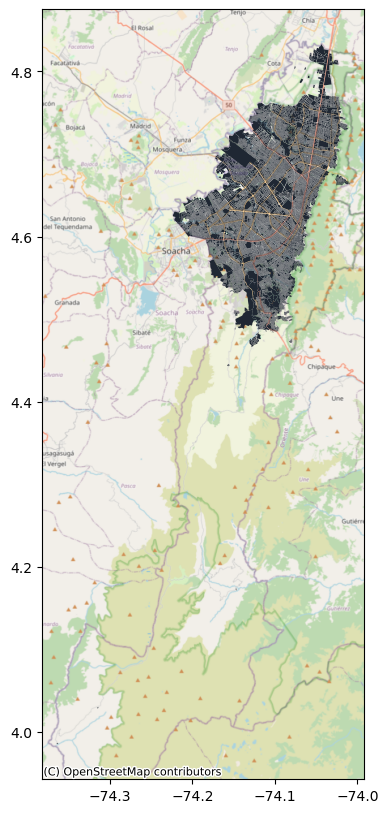

In [118]:
fig, ax = plt.subplots(figsize=(10, 10))
avaluo_manzana_shapefile.plot(ax=ax, color="#1f2733", markersize=10, alpha=1)
ctx.add_basemap(ax, crs=avaluo_manzana_shapefile.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

In [119]:
def nearest(row, geom_union, df1, df2, geom1_col='geometry', geom2_col='geometry', src_column=None):
    """Find the nearest point and return the corresponding value from specified column."""
    # Find the geometry that is closest
    nearest = df2[geom2_col] == nearest_points(row[geom1_col], geom_union)[1]
    # Get the corresponding value from df2 (matching is based on the geometry)
    value = df2[nearest][src_column].values[0]
    return value

In [120]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
unary_union = troncales_shapefile.unary_union

Calculamos el centroide de cada una de las manzanas

In [121]:
avaluo_manzana_shapefile['centroid'] = avaluo_manzana_shapefile.centroid
avaluo_manzana_shapefile.head()

C:\Users\PC\AppData\Local\Temp\ipykernel_28216\1010040113.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  avaluo_manzana_shapefile['centroid'] = avaluo_manzana_shapefile.centroid


,OBJECTID,MANZANA_ID,CP_TERR_AR,GRUPOP_TER,AVALUO_COM,AVALUO_CAT,OBSERVACIO,GLOBALID,SHAPE_Leng,SHAPE_Area,geometry,centroid
0,1,009259086,N,RESIDENCIAL,951874.0,733096.0,Este valor corresponde a la mediana y puede di...,{70BABE94-C17D-48FC-ADD0-BEF0283A45B4},0.002464,1.213815e-07,"POLYGON ((-74.12100 4.74751, -74.12101 4.74747...",POINT (-74.12149 4.74769)
1,2,001355027,N,RESIDENCIAL,973208.0,666239.0,Este valor corresponde a la mediana y puede di...,{73AA8E80-CC4E-4DF5-887F-E1620A2356E4},0.000684,2.818937e-08,"POLYGON ((-74.09776 4.55222, -74.09776 4.55221...",POINT (-74.09774 4.55234)
2,3,001355010,N,RESIDENCIAL,1100000.0,818602.0,Este valor corresponde a la mediana y puede di...,{ED6BDEF8-72FB-40F3-B4B5-A979800F5B47},0.000875,2.915943e-08,"POLYGON ((-74.09745 4.55194, -74.09747 4.55190...",POINT (-74.09755 4.55205)
3,4,001355012,N,RESIDENCIAL,687104.0,469428.0,Este valor corresponde a la mediana y puede di...,{2EBCB819-9A4E-4F41-9A8B-0578AE28045A},0.001018,3.175301e-08,"POLYGON ((-74.09723 4.55258, -74.09718 4.55258...",POINT (-74.09709 4.55254)
4,5,001355021,N,RESIDENCIAL,697258.0,474940.0,Este valor corresponde a la mediana y puede di...,{F25CC9EA-C4FA-49D6-9878-5EF2EBEE73FA},0.002131,9.812038e-08,"POLYGON ((-74.09668 4.55296, -74.09673 4.55288...",POINT (-74.09694 4.55280)


Usamos la función creada en un principio para calcular la estación más cercana de cada una de nuestras manzanas, y agregamos esta estación al shp

In [122]:
avaluo_manzana_shapefile['nearest_estación'] = avaluo_manzana_shapefile.apply(nearest, geom_union=unary_union, df1=avaluo_manzana_shapefile, df2=troncales_shapefile, geom1_col='centroid', src_column='nombre_est', axis=1)
avaluo_manzana_shapefile.head()

,OBJECTID,MANZANA_ID,CP_TERR_AR,GRUPOP_TER,AVALUO_COM,AVALUO_CAT,OBSERVACIO,GLOBALID,SHAPE_Leng,SHAPE_Area,geometry,centroid,nearest_estación
0,1,009259086,N,RESIDENCIAL,951874.0,733096.0,Este valor corresponde a la mediana y puede di...,{70BABE94-C17D-48FC-ADD0-BEF0283A45B4},0.002464,1.213815e-07,"POLYGON ((-74.12100 4.74751, -74.12101 4.74747...",POINT (-74.12149 4.74769),Portal de Suba
1,2,001355027,N,RESIDENCIAL,973208.0,666239.0,Este valor corresponde a la mediana y puede di...,{73AA8E80-CC4E-4DF5-887F-E1620A2356E4},0.000684,2.818937e-08,"POLYGON ((-74.09776 4.55222, -74.09776 4.55221...",POINT (-74.09774 4.55234),Portal 20 de Julio
2,3,001355010,N,RESIDENCIAL,1100000.0,818602.0,Este valor corresponde a la mediana y puede di...,{ED6BDEF8-72FB-40F3-B4B5-A979800F5B47},0.000875,2.915943e-08,"POLYGON ((-74.09745 4.55194, -74.09747 4.55190...",POINT (-74.09755 4.55205),Portal 20 de Julio
3,4,001355012,N,RESIDENCIAL,687104.0,469428.0,Este valor corresponde a la mediana y puede di...,{2EBCB819-9A4E-4F41-9A8B-0578AE28045A},0.001018,3.175301e-08,"POLYGON ((-74.09723 4.55258, -74.09718 4.55258...",POINT (-74.09709 4.55254),Portal 20 de Julio
4,5,001355021,N,RESIDENCIAL,697258.0,474940.0,Este valor corresponde a la mediana y puede di...,{F25CC9EA-C4FA-49D6-9878-5EF2EBEE73FA},0.002131,9.812038e-08,"POLYGON ((-74.09668 4.55296, -74.09673 4.55288...",POINT (-74.09694 4.55280),Portal 20 de Julio


Ahora debemos agrupar por estación (nearest_estacion) y sacar promedios de cada una de las manzanas asociadas a esa estación 

In [123]:
avaluo = avaluo_manzana_shapefile.groupby("nearest_estación").aggregate({"AVALUO_COM":[np.mean]})
avaluo

,AVALUO_COM
,mean
nearest_estación,
21 Ángeles,1.376036e+06
AV. 1 Mayo,1.177937e+06
AV. 39,1.870583e+06
AV. 68,2.365967e+06
AV. Américas - AV. Boyacá,1.831728e+06
...,...
U. Nacional,2.795671e+06
Universidades,1.092563e+06
